In [526]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import filterpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [546]:
def gen_rssi(distance, tx_power):
    return -30 * math.log(distance) + tx_power

def stationary(distance, seconds, PPS):
    return np.floor(np.asarray([gen_rssi(distance, 0) for x in range(int(PPS)*seconds)]))
                    
def moving(distance, velocity, seconds, PPS):
    A = []
    for t in range(seconds):
        for p in range(int(PPS)):
            A.append(gen_rssi(distance, 0))
            distance += velocity/PPS
    return np.floor(np.asarray(A))

def gen_data(PPS, rssi_std):
    data = np.concatenate((stationary(20,20, PPS),
                           moving(20,-0.5,30,PPS),
                           stationary(5,120,PPS), 
                            #moving(5,-0.5, 5,PPS), 
                            #stationary(2.5,60,PPS), 
                            #moving(2.5,1,17,PPS),
                            #stationary(20,60,PPS)))
            ))
    data += np.random.randn(len(data))*rssi_std
    return np.floor(data)

def seconds_to_sample(second):
    return PPS*second

steady state / total error: 0.6232683527775456/1.1506045235805766
converges to +=: 0.5660099341967019


None

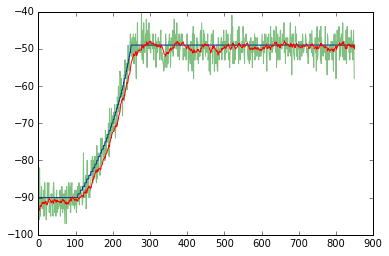

In [547]:
# G-H Playground

from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets import FloatSlider

def interactive_plot(error, PPS, g, h, dx, trials):
    walkabout = gen_data(PPS, 0)
    SSS = []
    AE = []
    SSE = []
    for trial in range(int(trials)):
        noisy_walkabout = gen_data(PPS, error)

        from filterpy.gh import GHFilter
        f = GHFilter (x=noisy_walkabout[0], dx=dx, dt=1.0/PPS, g=g, h=h)
        data = f.batch_filter(noisy_walkabout)
        variance = data[:,1]
        data = data[:,0]
        fig = plt.subplot()
        AE.append(np.mean(np.abs(walkabout-data.T[:-1])))
        SSS.append(np.std(data[second_to_sample(-20):]))
        SSE.append(np.mean(np.abs(data[second_to_sample(-20):]-walkabout[second_to_sample(-20):].T)))
    fig.plot(walkabout)
    fig.plot(noisy_walkabout, alpha=0.5)
    fig.plot(data)
    print("steady state / total error: {}/{}".format(np.mean(SSE), np.mean(AE)))
    print("converges to +=: {}".format(np.mean(SSS)))

interact(interactive_plot,
         error=FloatSlider(value=5, min=1., max=10, step=1), 
         PPS=FloatSlider(value=8, min=1., max=10, step=1), 
         g=FloatSlider(value=0.1, min=.000001, max=1., step=0.00001), 
         h=FloatSlider(value=0.0001, min=.000001, max=1., step=0.00001),
         dx=FloatSlider(value=0.25,min=0,max=2,step=0.25),
        trials=FloatSlider(value=10,min=1,max=50,step=1))  


Converges to :  0.646200758168
input / total / last half error: 3.9974117647058827 / 1.5403502150907182 / 0.6461439168780568


None

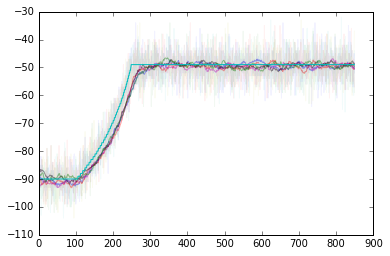

In [580]:
# Kalman, no hidden
    
def iplot_kalman(error, PPS, w_std, trials):
    PPS=int(PPS)
    walkabout = gen_data(PPS, 0)
    SSS = []
    SSE = []
    AE = []
    IE = []
    from filterpy.kalman import KalmanFilter
    from filterpy.common import Q_discrete_white_noise
    fig = plt.subplot()
    for trial in range(int(trials)):
        noisy_walkabout = gen_data(PPS, error)
        IE.append(np.mean(np.abs(noisy_walkabout-walkabout)))
    
        kf = KalmanFilter(dim_x=1, dim_z=1)
        kf.x = np.array([[noisy_walkabout[0]]])
        dt = 1.0/PPS
        kf.P = np.diag([10])
        kf.F = np.array([[1]])
        kf.Q = w_std**2
        kf.B = 0
        kf.H = np.array([[1.]])
        kf.R *= error**2
        # run the kalman filter and store the results
        xs, cov = [], []
        for z in noisy_walkabout:
            kf.predict()
            kf.update(z)
            xs.append(kf.x)
            cov.append(kf.P)

        xs, cov = np.array(xs), np.array(cov)
        fig.plot(xs[:,0], alpha=2./trials)
        fig.plot(noisy_walkabout, alpha=0.25/trials)
        SSS.append(np.std(xs[second_to_sample(-20):, 0]))
        AE.append(np.mean(np.abs(xs[:, 0].T-walkabout)))
        SSE.append(np.mean(np.abs(xs[second_to_sample(-20):, 0]-walkabout[second_to_sample(-20):])))
        
    
    fig.plot(walkabout)
    print("Converges to : ", np.mean(SSS))
    print("input / total / last half error: {} / {} / {}".format(np.mean(IE), np.mean(AE), np.mean(SSE)))
    #print(walkabout.size, xs[:,0].size, (xs[:, 0].T-walkabout).size)

interact(iplot_kalman,
         trials=FloatSlider(value=5, min=1, max=50, step=1),
         error=FloatSlider(value=5, min=0., max=10, step=0.5), 
         PPS=FloatSlider(value=5, min=1., max=10, step=1),
         w_std=FloatSlider(value=0.35, min=0.00000000001, max=0.5, step=0.000000001));

[[  4.00000000e-06   4.00000000e-05]
 [  4.00000000e-05   4.00000000e-04]]
[[  4.00000000e-06   4.00000000e-05]
 [  4.00000000e-05   4.00000000e-04]]
[[  4.00000000e-06   4.00000000e-05]
 [  4.00000000e-05   4.00000000e-04]]
[[  4.00000000e-06   4.00000000e-05]
 [  4.00000000e-05   4.00000000e-04]]
[[  4.00000000e-06   4.00000000e-05]
 [  4.00000000e-05   4.00000000e-04]]
Converges to :  0.456236942755
input / total / last half error: 2.415529411764706 / 1.1527742693158047 / 0.475133911569461


None

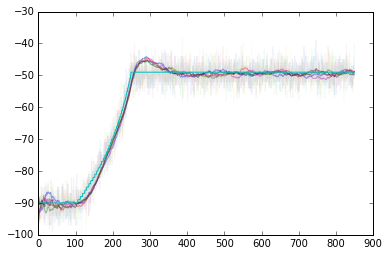

In [600]:
# Kalman, hidden RSSI'
    
def iplot_kalman(error, PPS, w_std, trials):
    PPS=int(PPS)
    walkabout = gen_data(PPS, 0)
    SSS = []
    SSE = []
    AE = []
    IE = []
    from filterpy.kalman import KalmanFilter
    from filterpy.common import Q_discrete_white_noise
    fig = plt.subplot()
    for trial in range(int(trials)):
        noisy_walkabout = gen_data(PPS, error)
        IE.append(np.mean(np.abs(noisy_walkabout-walkabout)))
    
        kf = KalmanFilter(dim_x=2, dim_z=1)
        kf.x = np.array([[noisy_walkabout[0]],
                     [0]])
        dt = 1.0/PPS
        kf.P = np.diag([10, 10*dt])
        kf.F = np.array([[1, dt,],
                         [0, 1]])
        kf.Q = Q_discrete_white_noise(dim=2, dt=1/PPS, var=w_std**2)
        #print(kf.Q)
        kf.B = 0
        kf.H = np.array([[1., 0.]])
        kf.R *= error**2
        # run the kalman filter and store the results
        xs, cov = [], []
        for z in noisy_walkabout:
            kf.predict()
            kf.update(z)
            xs.append(kf.x)
            cov.append(kf.P)

        xs, cov = np.array(xs), np.array(cov)
        fig.plot(xs[:,0], alpha=2./trials)
        fig.plot(noisy_walkabout, alpha=0.25/trials)
        SSS.append(np.std(xs[second_to_sample(-20):, 0]))
        AE.append(np.mean(np.abs(xs[:, 0].T-walkabout)))
        SSE.append(np.mean(np.abs(xs[second_to_sample(-20):, 0]-walkabout[second_to_sample(-20):])))
        
    
    fig.plot(walkabout)
    print("Converges to : ", np.mean(SSS))
    print("input / total / last half error: {} / {} / {}".format(np.mean(IE), np.mean(AE), np.mean(SSE)))
    #print(walkabout.size, xs[:,0].size, (xs[:, 0].T-walkabout).size)

interact(iplot_kalman,
         trials=FloatSlider(value=5, min=1, max=50, step=1),
         error=FloatSlider(value=5, min=0., max=10, step=0.5), 
         PPS=FloatSlider(value=5, min=1., max=10, step=1),
         w_std=FloatSlider(value=0.35, min=0.00000000001, max=0.5, step=0.000000001));

Converges to :  0.680587499243
input / total / last half error: 2.377411764705882 / 0.8971029452280741 / 0.5726249885031025


None

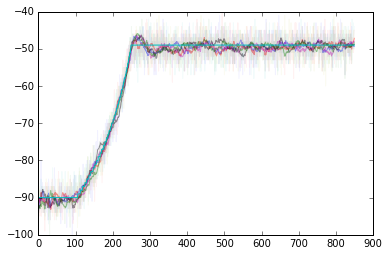

In [579]:
# Kalman, hidden RSSI' & RSSI''
    
def iplot_kalman(error, PPS, w_std, trials):
    PPS=int(PPS)
    walkabout = gen_data(PPS, 0)
    SSS = []
    SSE = []
    AE = []
    IE = []
    from filterpy.kalman import KalmanFilter
    from filterpy.common import Q_discrete_white_noise
    fig = plt.subplot()
    for trial in range(int(trials)):
        noisy_walkabout = gen_data(PPS, error)
        IE.append(np.mean(np.abs(noisy_walkabout-walkabout)))
    
        kf = KalmanFilter(dim_x=3, dim_z=1)
        kf.x = np.array([[noisy_walkabout[0]],
                     [0],[0]])
        dt = 1.0/PPS
        kf.P = np.diag([10, 10*dt, 10*dt*dt])
        kf.F = np.array([[1, dt,dt*dt/2],
                         [0, 1, dt],
                         [0, 0, 1]])
        kf.Q = Q_discrete_white_noise(dim=3, dt=1/PPS, var=w_std**2)
        kf.B = 0
        kf.H = np.array([[1., 0., 0.]])
        kf.R *= error**2
        # run the kalman filter and store the results
        xs, cov = [], []
        for z in noisy_walkabout:
            kf.predict()
            kf.update(z)
            xs.append(kf.x)
            cov.append(kf.P)

        xs, cov = np.array(xs), np.array(cov)
        fig.plot(xs[:,0], alpha=2./trials)
        fig.plot(noisy_walkabout, alpha=0.25/trials)
        SSS.append(np.std(xs[second_to_sample(-20):, 0]))
        AE.append(np.mean(np.abs(xs[:, 0].T-walkabout)))
        SSE.append(np.mean(np.abs(xs[second_to_sample(-20):, 0]-walkabout[second_to_sample(-20):])))
        
    
    fig.plot(walkabout)
    print("Converges to : ", np.mean(SSS))
    print("input / total / last half error: {} / {} / {}".format(np.mean(IE), np.mean(AE), np.mean(SSE)))
    #print(walkabout.size, xs[:,0].size, (xs[:, 0].T-walkabout).size)

interact(iplot_kalman,
         trials=FloatSlider(value=5, min=1, max=50, step=1),
         error=FloatSlider(value=3, min=0., max=10, step=0.5), 
         PPS=FloatSlider(value=5, min=1., max=10, step=1),
         w_std=FloatSlider(value=0.015, min=0.001, max=0.2, step=0.00025));

Converges to :  1.56925096935
input / total / last half error: 2.4037647058823532 / 1.5572470588235299 / 1.3853333333333335


None

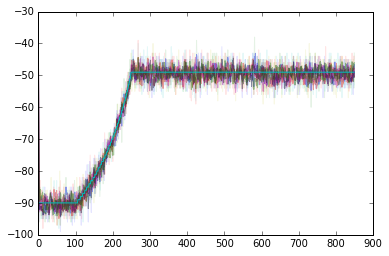

In [599]:
# Weighted Sliding Window

np.array([[0.2, 0.2, 0.2, 0.2, 0.2]])


class WeightedSlidingWindow:
    def __init__(self, weights):
        self.weights = np.array(weights)
        self.state = [0 for i in self.weights]
    def next(self, z):
        self.state.append(z)
        self.state.pop(0)
        return np.dot(self.weights, self.state)
    
def iplot_wsw(error, PPS, trials):
    PPS=int(PPS)
    walkabout = gen_data(PPS, 0)
    fig = plt.subplot()
    SSS = []
    SSE = []
    AE = []
    IE = []
    for trial in range(int(trials)):
        wsw = WeightedSlidingWindow(weights)
        noisy_walkabout = gen_data(PPS, error)
        IE.append(np.mean(np.abs(noisy_walkabout.T-walkabout)))
        xs, cov = [], []
        for z in noisy_walkabout:
            xs.append(wsw.next(z))

        xs = np.array(xs)
        fig.plot(xs, alpha=2./trials)
        fig.plot(noisy_walkabout, alpha=0.5/trials)
        SSS.append(np.std(xs[second_to_sample(-20):]))
        AE.append(np.mean(np.abs(xs.T-walkabout)))
        SSE.append(np.mean(np.abs(xs[second_to_sample(-20):]-walkabout[second_to_sample(-20):])))
        
    
    fig.plot(walkabout)
    print("Converges to : ", np.mean(SSS))
    print("input / total / last half error: {} / {} / {}".format(np.mean(IE), np.mean(AE), np.mean(SSE)))
    #print(walkabout.size, xs.size, (xs.T-walkabout).size)

interact(iplot_wsw,
         trials=FloatSlider(value=5, min=1, max=50, step=1),
         error=FloatSlider(value=3, min=0., max=10, step=0.5), 
         PPS=FloatSlider(value=5, min=1., max=10, step=1));

[RAW] Std:  3.0203457464
[KF] Std:  0.740061068089


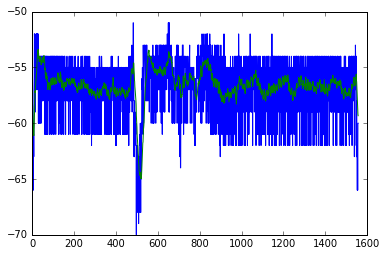

In [616]:
import csv

raw = []
kf = []

with open('ble.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        raw.append(row[0])
        kf.append(row[1])
fig = plt.subplot()
raw = np.array(raw, dtype=np.int8)
kf = np.array(kf, dtype=np.float64)
print("[RAW] Std: ", np.std(raw[len(raw)//2:]))
print("[KF] Std: ", np.std(kf[len(kf)//2:]))
fig.plot(raw)
fig.plot(kf);